# Figure 2: Meteo conditions during events
With this jupyter notebook you can generates Figure 2 of:  van der Most et al. Temporally compounding energy droughts in European electricity systems with hydropower

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy import stats
import numpy as np

import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
import geopandas
from shapely.geometry.multipolygon import MultiPolygon
from  shapely.geometry.polygon import Polygon 

# Plotting settings
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.sans-serif'] = ["Helvetica", "Arial", "sans-serif"]
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 7
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['xtick.labelsize'] = 5
mpl.rcParams['ytick.labelsize'] = 5


In [2]:
# Load data
folder = 'data_for_images/'
runname = 'LENTIS_PD_02_v4'

#reservoir data
reservoirall = {c: pd.read_csv(folder + f'fig2_{c}_reservoir_around_event.csv', index_col=0) for c in ['NOR', 'FRA', 'ITA']}

# meteo data
ds = xr.open_dataset(folder+'fig2_meteorological_data_during_event.nc')
dsttest = xr.open_dataset(folder+'fig2_ttests.nc')
sea_level_pressure = xr.open_dataset(folder+'psl_during_event.nc')

colors_seasons = {
    'winter': '#0000FF',
    'summer': '#FFB14E',
    'all': '#E8246F',
}


# first part of figure

<ipython-input-3-695b51ff6995>:63: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.08, wspace=0.02)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial, sans-serif


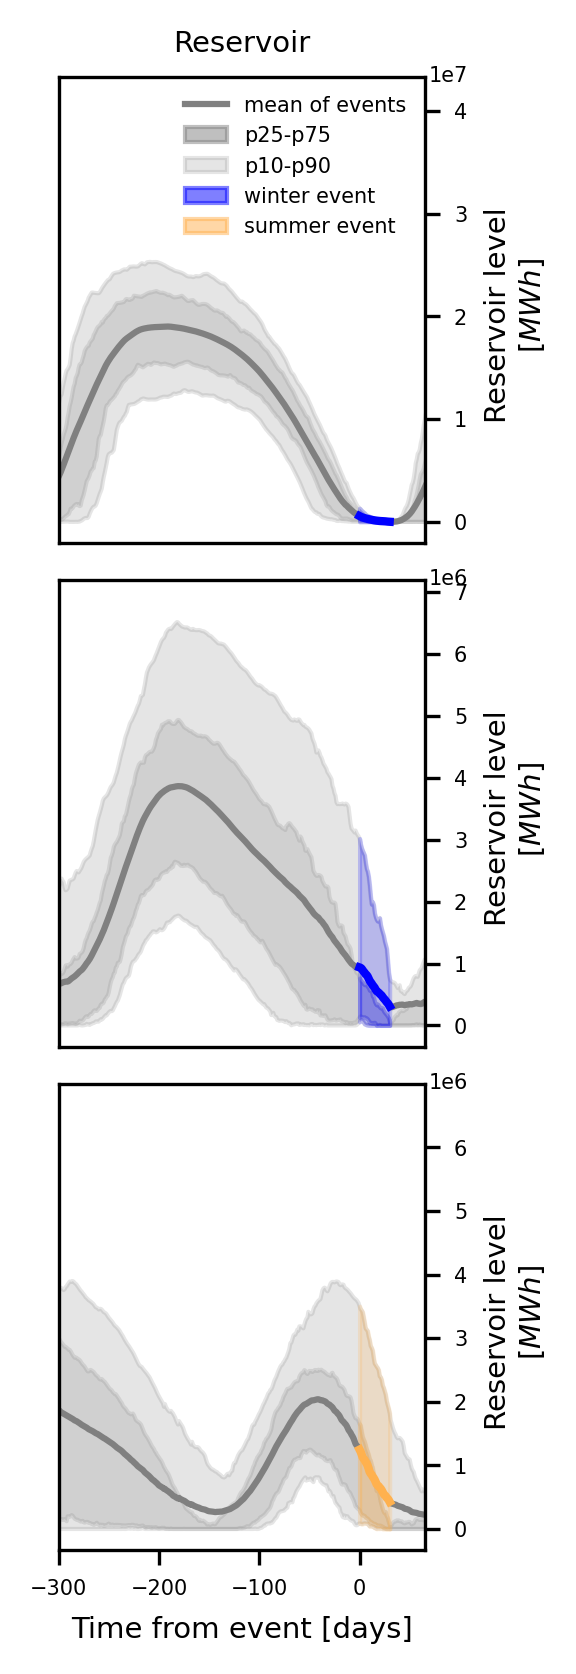

In [3]:
# Define figure size
width_mm = 40
height_mm = 162
width_in = width_mm / 25.4
height_in = height_mm / 25.4

fig, axs = plt.subplots(3, 1, figsize=[width_in, height_in], constrained_layout=True, dpi=300)

scientific_notation = ['1e7', '1e6', '1e6']
scalar = [1e7, 1e6, 1e6]

handles_list = []
labels_list = []

for n, country in enumerate(['NOR', 'FRA', 'ITA']):
    ax = axs[n]
    col = 'summer' if country == 'ITA' else 'winter'

    dft2 = reservoirall[country] / scalar[n]
    line1 = dft2.mean(axis=1).plot(legend=False, ax=ax, color='grey', label='mean')
    handles_list.append(mlines.Line2D([], [], color='grey', label='mean'))
    labels_list.append('mean of events')

    fill1 = ax.fill_between(dft2.index, dft2.quantile(0.75, axis=1), dft2.quantile(0.25, axis=1), color='grey', alpha=0.2, label='25th-75th percentile')
    fill1_handle = mpatches.Patch(color='grey', alpha=0.5)
    handles_list.append(fill1_handle)
    labels_list.append('p25-p75')

    fill2 = ax.fill_between(dft2.index, dft2.quantile(0.9, axis=1), dft2.quantile(0.1, axis=1), color='grey', alpha=0.2, label='10th-90th percentile')
    handles_list.append(fill2)
    labels_list.append('p10-p90')

    dft3 = dft2.loc[0:30]
    line2 = dft3.mean(axis=1).plot(legend=False, ax=ax, color=colors_seasons[col], linewidth=2)
    handles_list.append(line2)
    labels_list.append(col + ' event')

    fill3 = ax.fill_between(dft3.index, dft3.quantile(0.75, axis=1), dft3.quantile(0.25, axis=1), color=colors_seasons[col], alpha=0.2)
    fill4 = ax.fill_between(dft3.index, dft3.quantile(0.9, axis=1), dft3.quantile(0.1, axis=1), color=colors_seasons[col], alpha=0.2)
    handles_list.append(mpatches.Patch(color=colors_seasons[col], alpha=0.5))
    labels_list.append(col + ' event')

    ax.set_xlabel('Time from event [days]')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('Reservoir level \n [$MWh$]')
    ax.set_xlim(-300, 65)

    if n == 0:
        ax.set_title('Reservoir', fontsize=7)

    if n in [0, 1]:
        ax.set_xlabel('')
        ax.set_xticks([])

    ax.text(1.01, 0.99, scientific_notation[n], transform=ax.transAxes, size=5)

unique_handles_labels = dict(zip(labels_list, handles_list))
unique_handles = list(unique_handles_labels.values())
unique_labels = list(unique_handles_labels.keys())

axs[0].legend(unique_handles, unique_labels, fontsize=5, frameon=False)
fig.subplots_adjust(hspace=0.08, wspace=0.02)
plt.show()

# second part of figure

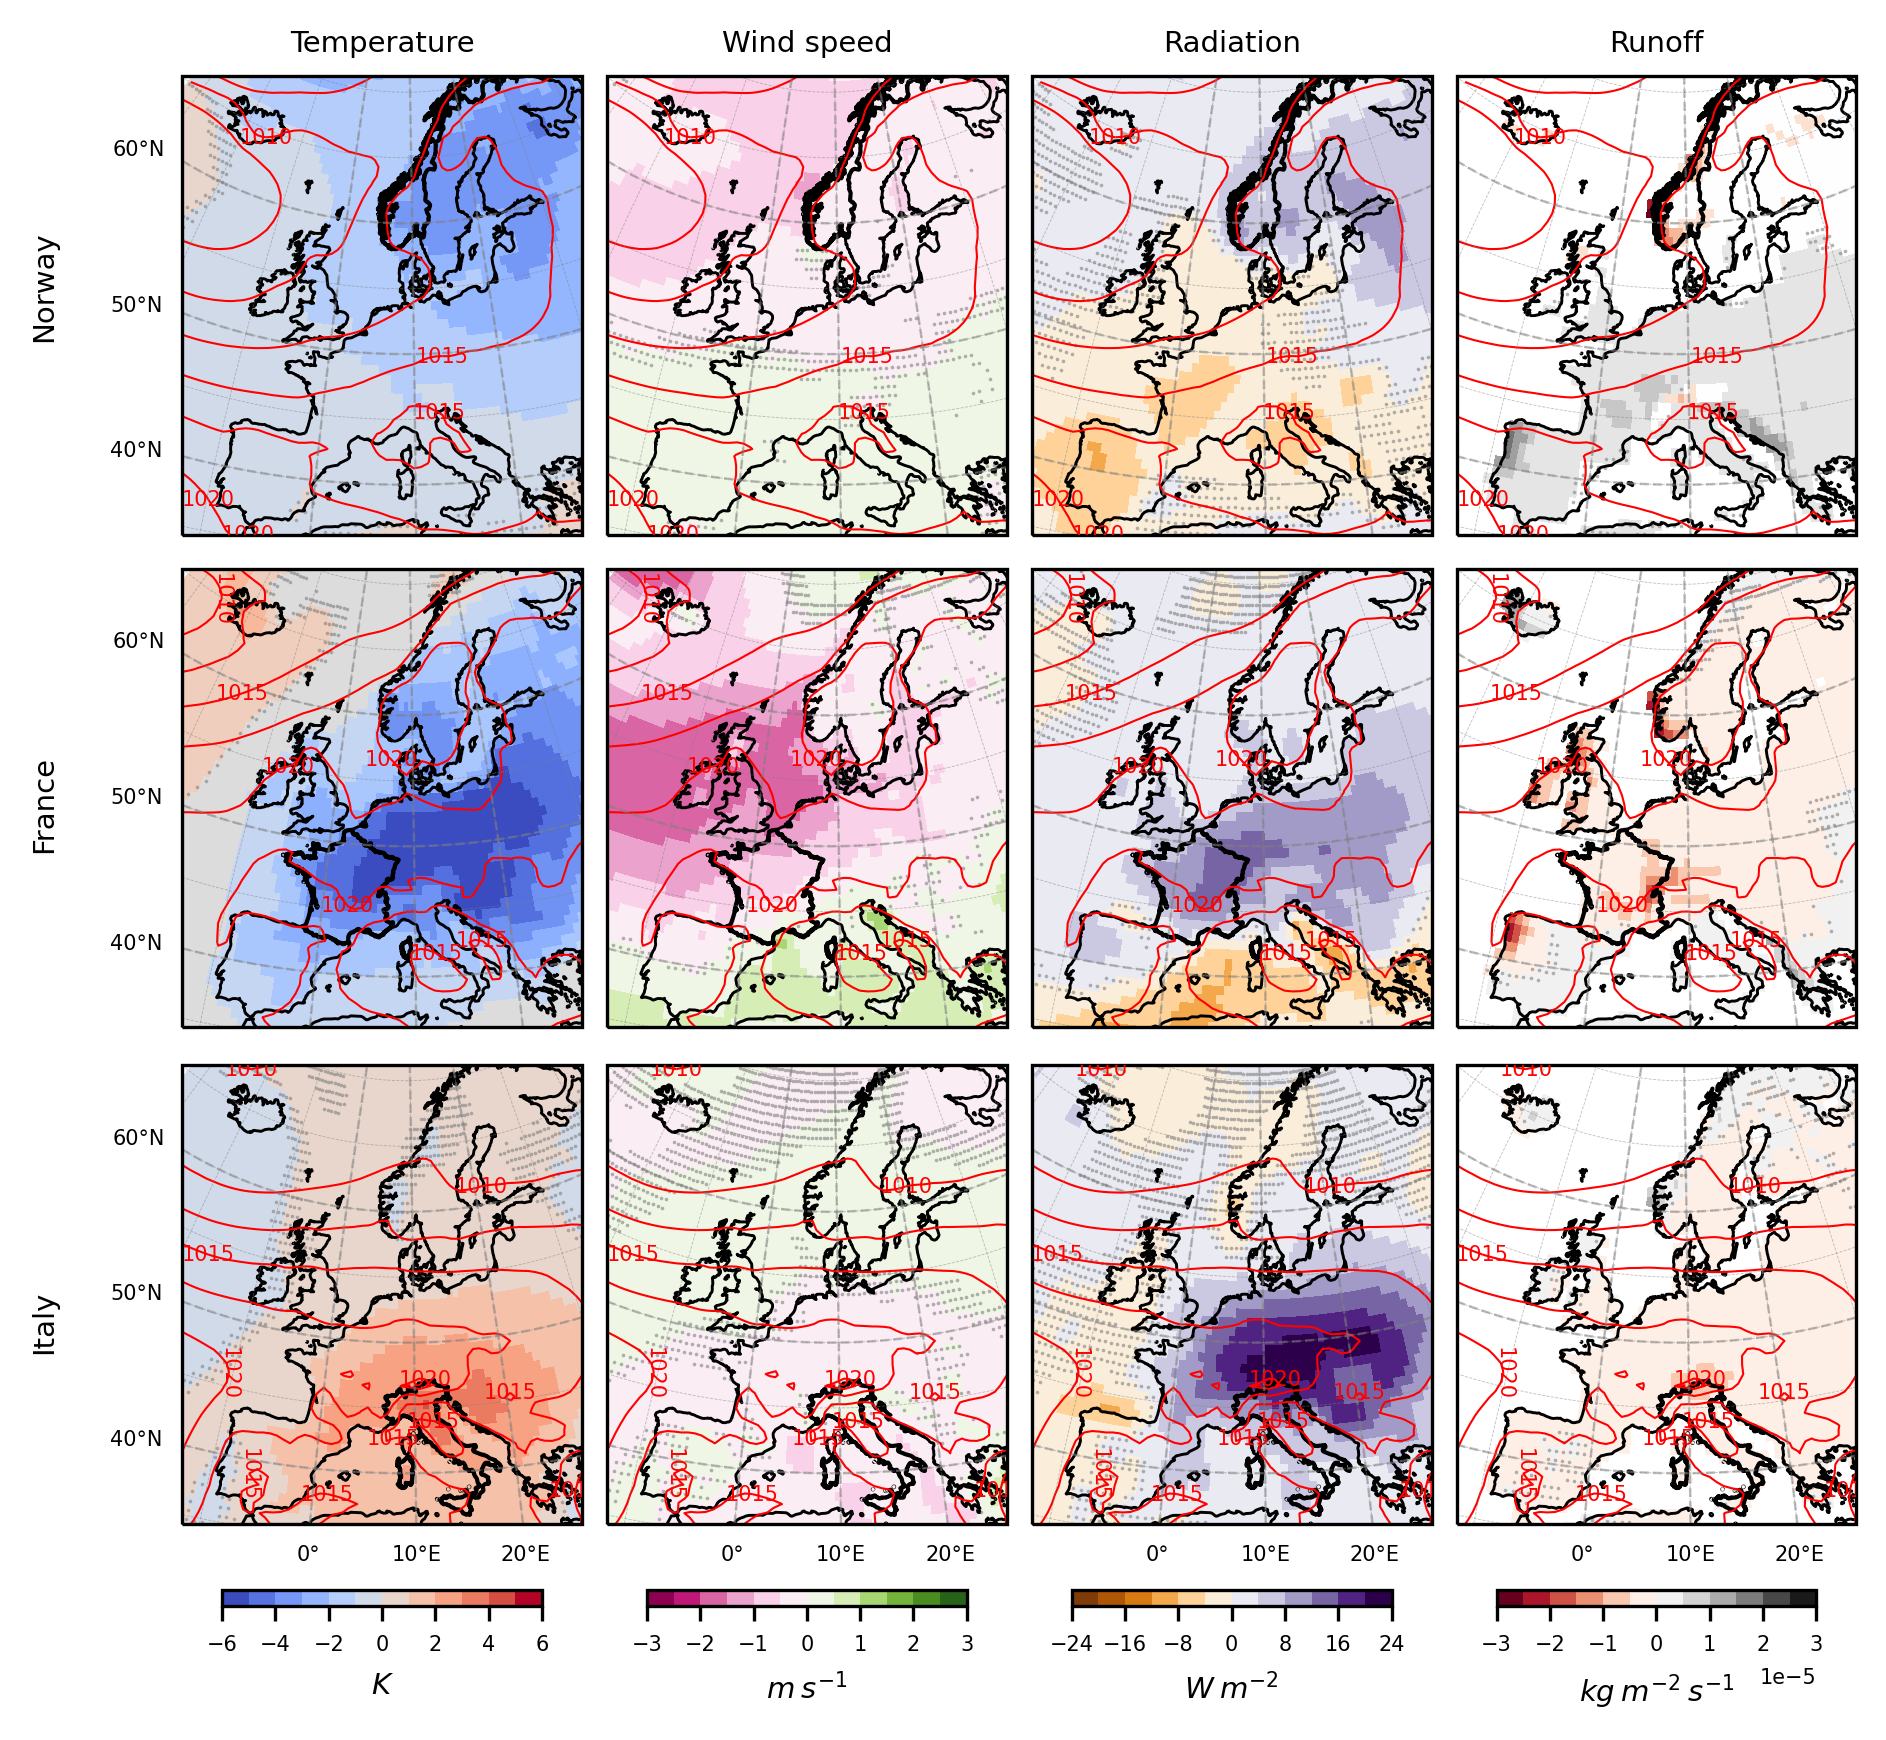

In [4]:
variabs = ['tas', 'sfcWind', 'rsds', 'mrro']

dict_names = {
    'tas': 'Temperature',
    'sfcWind': 'Wind speed',
    'rsds': 'Radiation',
    'mrro': 'Runoff'
}

varunits = {
    'tas': '$K$', 
    'sfcWind': '$m\:s^{-1}$', 
    'rsds': '$W\:m^{-2}$', 
    'mrro': '$kg\:m^{-2}\:s^{-1}$'
}

width_mm = 150
height_mm = (11.5 / 12) * width_mm
if height_mm > 185:
    print('TOO HIGH!')

width_in = width_mm / 25.4
height_in = height_mm / 25.4

fig, axs = plt.subplots(3, 4, figsize=[width_in, height_in], subplot_kw=dict(projection=ccrs.EuroPP()), constrained_layout=True, dpi=300)

cmaps = ['coolwarm', 'PiYG', 'PuOr', 'RdGy']
levels = [
    np.arange(-6, 7, 1),
    np.arange(-3, 3.5, 0.5),
    np.arange(-24, 28, 4),
    np.arange(-3 * 1e-5, 3.5 * 1e-5, 1 * 0.5e-5)
]
levelsp = np.arange(990, 1030, 2.5)

resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'
shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

def fmt(x):
    s = f"{x:.0f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"


for i, var in enumerate(variabs):
    for j, (country, season) in enumerate(zip(['NOR', 'FRA', 'ITA'], ['winter', 'winter', 'summer'])):
        ax = axs[j, i]
        if j == 0:
            ax.set_title(f'{dict_names[var]}', fontsize=7)
        
        poly = df.loc[df['ADM0_A3'] == country]['geometry'].values[0]
        if isinstance(poly,Polygon):
            poly = MultiPolygon([poly])

        ax.coastlines(resolution='50m', linewidth=0.7)
        ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', linewidth=1, edgecolor='black')

        CS = (sea_level_pressure['psl'].sel(country=country, season=season) / 100).plot.contour(
            ax=ax, colors='red', levels=levelsp, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, linewidths=0.5
        )
        ax.clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=5)

        pcm = ds[var].sel(country=country, season=season).plot(
            cmap=cmaps[i], ax=ax, transform=ccrs.PlateCarree(), levels=levels[i], add_colorbar=False, add_labels=False
        )

        dsm = dsttest.sel(country=country)
        dft = dsm[var + '_valid'].to_dataframe().reset_index()
        dft = dft.loc[dft[var + '_valid'] > 0, :]
        non_significant_lon = dft.lon.values
        non_significant_lat = dft.lat.values

        ax.scatter(non_significant_lon, non_significant_lat, color='grey', s=3, marker='.', transform=ccrs.PlateCarree(), alpha=0.6, lw=0)

        gl0 = ax.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl = ax.gridlines(draw_labels=False, linewidth=0.6, color='gray', alpha=0.5, linestyle='--', x_inline=False)
        gl.xlabel_style = {'size': 5, 'rotation': 0}
        gl.ylabel_style = {'size': 5, 'rotation': 0}
        gl.xlocator = plt.FixedLocator([0, 10, 20])
        gl.ylocator = plt.FixedLocator([40, 50, 60])

        if ax == axs[2, i]:
            gl.bottom_labels = True
        if ax == axs[j, 0]:
            gl.left_labels = True

    cbar = plt.colorbar(pcm, ax=axs[j, i], shrink=0.8, location='bottom')
    cbar.set_label(varunits[var], fontsize=7)

row_titles = ['Norway', 'France', 'Italy']
for i, title in enumerate(row_titles):
    fig.text(-0.03, 0.845 - i * (0.305), title, va='center', ha='center', rotation=90, fontsize=7)

plt.show()